<a href="https://colab.research.google.com/github/Torbey/JProg/blob/master/Monte_Carlo_Markowitz_Portfolio_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Import relevant libraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

# stocks = ['C', 'AMD', 'XOM', 'SBUX', 'CVS']
# stocks = ['BAC', 'GS', 'JPM', 'MS']
# stocks = ['SPY', 'JPM', 'AMZN', 'AAPL']
stocks = ['BAC', 'GS', 'JPM', 'MS', 'AAPL', 'C', 'AMD', 'XOM', 'SBUX', 'CVS', 'AMZN']
data = web.DataReader(stocks,data_source="yahoo",start='10/01/2017',end='12/06/2019')['Adj Close']
#print(data)



In [0]:
# Sort data by date in ascending order (it usually comes sorted)
data = data.sort_index()
#print(data)

In [0]:
returns = data/data.shift(1)-1 #can also use data.pct_change()
#print(returns)
# Increase the Size of the Plot
plt.rcParams["figure.figsize"] = (20,10)
returns.plot()

In [0]:
returns.dropna(inplace=True)
#print(returns)

In [0]:
#np.random.seed(seed) 

n = 10
dt = 1 # time step
b = np.random.normal(0., 1., (1000,n))*np.sqrt(dt)  # brownian increments
print(len(b))
print(len(b[0]))
s0 = data['AMD'].mean()
sh0 = b.shape
b = b+1
print(b)
# [f(x) for x in sequence if condition]
# [f(x) if condition else g(x) for x in sequence]
#b = [f(x) if condition else g(x) for x in sequence]
b = np.array([[s0*v if i == 0 else row[i-1]*v for i,v in enumerate(row)] for row in b])
print(b)
np.reshape(b, sh0)
b


In [0]:
#Calculate the stocks' mean returns and covariances
mean_returns = returns.mean()
cov_matrix = returns.cov()

#annualize returns
mean_returns = (1+mean_returns)**252 - 1
#annualize varcovar
cov_matrix *= 252

print(mean_returns)
print(cov_matrix)

In [0]:
def simulate(stocks, num_iterations):
  import math
  simulation_res = np.zeros((3+len(stocks),num_iterations))
  for i in range(num_iterations):
      #Select random weights and normalize to set the sum to 1
      weights = np.array(np.random.random(len(stocks)))
      weights /= np.sum(weights)
      #Calculate the return and standard deviation for every step
      portfolio_return = sum(mean_returns * weights)
      portfolio_std_dev = math.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
      #Store all the results in a defined array
      simulation_res[0,i] = portfolio_return
      simulation_res[1,i] = portfolio_std_dev
      #Calculate Sharpe ratio and store it in the array
      simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
      #Save the weights in the array
      for j in range(len(weights)):
          simulation_res[j+3,i] = weights[j]
  return simulation_res

In [0]:
def simulate_improved(stocks, num_iterations):
  simulation_res = np.zeros((num_iterations,3+len(stocks)))
  ww = np.random.random((num_iterations,len(stocks)))                    
  weights = np.array([row/sum(row) for row in ww])
  portfolio_return = np.dot(weights,mean_returns)
  portfolio_std_dev = np.array([math.sqrt(np.dot(weight_row.T,np.dot(cov_matrix, weight_row))) for weight_row in weights])
  portfolio_sharpe_ratio = portfolio_return / portfolio_std_dev
  simulation_res[:,0] = portfolio_return
  simulation_res[:,1] = portfolio_std_dev
  simulation_res[:,2] = portfolio_sharpe_ratio
  simulation_res[:,3:3+len(stocks)] = weights
  return simulation_res

In [0]:
def simulate_improved_multiple_returns(stocks, num_iterations):
  weight_matrix = np.random.random((num_iterations,len(stocks)))                    
  weight_matrix = np.array([row/sum(row) for row in weight_matrix])
  
  portfolio_returns = np.dot(weights,mean_returns)
  portfolio_std_devs = np.array([math.sqrt(np.dot(weight_row.T,np.dot(cov_matrix, weight_row))) for weight_row in weight_matrix])
  portfolio_sharpe_ratios = portfolio_returns / portfolio_std_devs
  
  return portfolio_returns, portfolio_std_devs, portfolio_sharpe_ratios, weight_matrix

In [9]:
#Set the number of iterations and define an array to hold the simulation results; initially set to all zeros
import time, math
num_iterations = 10000000
# start_time = time.time()
# simulation_res = simulate(stocks, num_iterations)
# end_time = time.time()
# print(str(end_time-start_time))
start_time = time.time()
simulation_res = simulate_improved(stocks, num_iterations)
end_time = time.time()
print(str(end_time-start_time))

287.46758460998535


In [0]:
fields=['ret','stdev','sharpe']
fields.extend(stocks)
# sim_frame = pd.DataFrame(simulation_res.T,columns=fields)
sim_frame = pd.DataFrame(simulation_res,columns=fields)
#print(sim_frame.head (5))
#print(sim_frame.tail (5))

In [0]:
#Spot the position of the portfolio with highest Sharpe Ratio
max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]
#Spot the position of the portfolio with minimum Standard Deviation
min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]
#print("The portfolio for max Sharpe Ratio:\n", max_sharpe)
#print("The portfolio for min risk:\n", min_std)

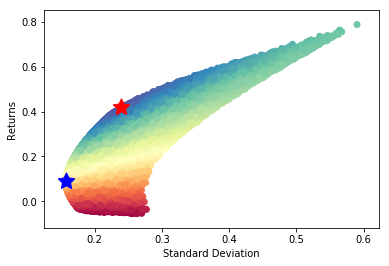

In [12]:
# Increase the Size of the Plot
# plt.rcParams["figure.figsize"] = (20,10)

#Create a scatter plot coloured by various Sharpe Ratios with standard deviation on the x-axis and returns on the y-axis
# plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='RdYlBu')
plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='Spectral')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

minret = sim_frame['ret'].min(axis=0)
maxret = sim_frame['ret'].max(axis=0)

minstd = sim_frame['stdev'].min(axis=0)
maxstd = sim_frame['stdev'].max(axis=0)

adj_ret_coeff = abs((maxret-minret))*0.075
adj_std_coeff = abs((maxstd-minstd))*0.075

#print("{}, {}, {}, {}".format(coeff_maxret, coeff_maxstd, coeff_minret, coeff_minstd))

plt.ylim(minret-adj_ret_coeff,maxret+adj_ret_coeff)
plt.xlim(minstd-adj_std_coeff,maxstd+adj_std_coeff)

#Red Star : Maximum Sharpe Ratio Portfolio
plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=300)
#Blue Star: Minimum Variance Portfolio
plt.scatter(min_std[1],min_std[0],marker=(5,1,0),color='b',s=300)

plt.show()